In [1]:
from typing import Any, Dict
import gym
import numpy as np
import tensorflow as tf
from tensorflow_probability.python.distributions import JohnsonSU
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class PreProcessor:
    def __init__(self, env: gym.Env, name: str='preprocessor') -> None:
        self.__name__ = name
        self.env = env
        self.state_params = self.get_mu_sigma(self.env)

    def get_mu_sigma(self, env: gym.Env):
        highs: tuple[float, float] = env.observation_space.high  # type: ignore
        lows: tuple[float, float] = env.observation_space.low  # type: ignore
        loc_extremes = [lows[0], highs[0]]
        vel_extremes = [lows[1], highs[1]]
        return np.array([loc_extremes, vel_extremes])

    def min_max_normalize(self, state):
        if not isinstance(state, np.ndarray):
            state=np.array(state, dtype=np.float32)
        result = (state - self.state_params[0:, 0]) / \
            (self.state_params[0:, 1] - self.state_params[0:, 0])
        return result*2 - 1

    def call(self, state: np.ndarray) -> np.ndarray:
        return self.min_max_normalize(state)

In [3]:
class params(tf.keras.layers.Layer):
    def __init__(self, trainable:bool=True, name:str='params', dtype=None, dynamic:bool=False, **kwargs):
        super(params, self).__init__(trainable=trainable,
                                     name=name, dtype=dtype, dynamic=dynamic, **kwargs)

    def call(self, inputs, **kwds: Any):
        probs0, probs1, mu, sigma = tf.split(inputs, 4, axis=-1)
        probs = tf.concat([probs0, probs1], axis=-1)
        choice = tf.random.categorical(logits=tf.math.log(
            probs), num_samples=1, dtype=tf.int32)
        PARAMS = tf.constant([[-1.8, 2.5], [1.8, 2.5]],
                             dtype=tf.float32, shape=(2, 2))
        params = tf.gather(PARAMS, indices=choice, axis=1)
        skew, tail = tf.split(params, 2, axis=0)
        dist = JohnsonSU(loc=mu, scale=sigma, skewness=skew, tailweight=tail)
        action = dist.sample()
        action = tf.reshape(action, [1, 1])
        choice = tf.cast(choice, tf.float32)
        result = tf.concat([action, choice, probs0, probs1], axis=-1)
        return result

    def get_config(self):
        config = super(params, self).get_config()
        return config

In [4]:
def policy_loss(y_true, y_pred):
    action_choice_probs = y_pred
    action, choice, probs0, probs1 = tf.split(action_choice_probs, 4, axis=-1)
    probs = tf.concat([probs0, probs1], axis=-1)
    state = y_true
    _, vel = tf.split(state, 2, axis=-1)
    reference = JohnsonSU(loc=tf.sign(tf.squeeze(vel))*1.2,
                          scale=tf.constant(0.35), skewness=tf.sign(tf.squeeze(vel))*1.35, tailweight=tf.constant(1.25))
    action = tf.squeeze(action)
    choice = tf.squeeze(choice)
    probs = tf.squeeze(probs)
    loss_0 = -reference.log_prob(action)
    loss_1 = tf.keras.losses.sparse_categorical_crossentropy(choice, probs)
    loss = tf.math.add(loss_0, loss_1)
    return loss


In [5]:
def make_policy(lr):
    ones = tf.initializers.Ones()
    input = tf.keras.layers.Input(shape=(2), batch_size=1, dtype='float32')
    flatten = tf.keras.layers.Flatten()(input)
    dense_probs = tf.keras.layers.Dense(
        64, activation=tf.keras.activations.linear)(flatten)
    probs = tf.keras.layers.Dense(
        2, activation=tf.keras.activations.softmax)(dense_probs)
    mu = tf.keras.layers.Dense(64, activation=tf.keras.activations.linear)(
        flatten)
    sigma = tf.keras.layers.Dense(
        64, activation=tf.keras.activations.linear)(flatten)
    mu = tf.keras.layers.Dense(1, activation=tf.keras.activations.linear)(mu)
    sigma = tf.keras.layers.Dense(
        1, activation=tf.keras.activations.exponential, kernel_initializer=ones)(sigma)  # type: ignore
    vars = tf.keras.layers.Concatenate(axis=-1)([mu, sigma])
    inpts = tf.keras.layers.Concatenate(axis=-1)([probs, vars])
    action_choice_probs = params()(inpts)
    value_est = tf.keras.layers.Dense(
        64, activation=tf.keras.activations.linear)(flatten)
    value_est = tf.keras.layers.Dense(
        1, activation=tf.keras.activations.linear)(value_est)
    policy = tf.keras.Model(inputs=input, outputs=[
                            action_choice_probs, value_est])
    policy.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=[policy_loss,
                                                                               tf.keras.losses.mean_absolute_error], loss_weights=[0.90, 0.10])
    return policy
    

In [6]:

def run_episode(num_steps: int, env: gym.Env, policy: tf.keras.Model, preprocessor: PreProcessor):
    done0, done1 = False, False
    step = -1
    pol_losses = []
    s0, _ = env.reset()
    s0 = np.expand_dims(s0, 0)
    s0 = preprocessor.call(s0)
    gamma = 0.99
    lambda_ = 1.0
    while not (done0 or done1):
        step += 1
        action_choice_probs, _ = policy(s0)  # type: ignore
        action, _, _, _ = np.split(
            action_choice_probs, 4, axis=-1)

        action = np.clip(np.squeeze(action), -1.0, 1.0)
        s1, reward, done0, done1, _ = env.step([action])
        s1 = np.expand_dims(s1, 0)
        s1 = preprocessor.call(s1)
        pol_step_loss = policy.train_on_batch(
            s0, y=[np.array([s0]), np.array([reward])], reset_metrics=False)
        pol_losses.append(pol_step_loss[0])
        if step == num_steps:
            done1 = True
        else:
            s0 = s1
            if not lambda_ == 0.0:
                if not np.can_cast(lambda_*gamma, np.float32):
                    lambda_ = 0.0
                else:
                    lambda_ = lambda_ * gamma
    return pol_losses, step, policy

In [7]:
def actor_critic(num_steps:int, num_episodes:int, env: gym.Env, lr:float):
    i = -1
    preprocessor = PreProcessor(env)
    policy = make_policy(lr)
    loss_dict: Dict[str, list[float]] = {}
    loss_dict['pol_losses'] = []
    for _ in range(1, num_episodes+1):
        i += 1
        print('Beginning episode ', i, '...')
        pol_losses, steps, policy = run_episode(
            num_steps, env, policy, preprocessor)
        loss_dict['pol_losses'].extend(pol_losses)
        print('Episode ', i, ' completed in ', steps, ' steps.\n\n')
    return policy, loss_dict, env

In [8]:
lr = 0.01
num_steps = 600
num_episodes = 5
env = gym.make('MountainCarContinuous-v0')    
policy, losses_dict, env = actor_critic(
num_steps, num_episodes, env, lr)
env.close()


Beginning episode  0 ...
Episode  0  completed in  91  steps.


Beginning episode  1 ...
Episode  1  completed in  121  steps.


Beginning episode  2 ...
Episode  2  completed in  88  steps.


Beginning episode  3 ...
Episode  3  completed in  97  steps.


Beginning episode  4 ...
Episode  4  completed in  183  steps.




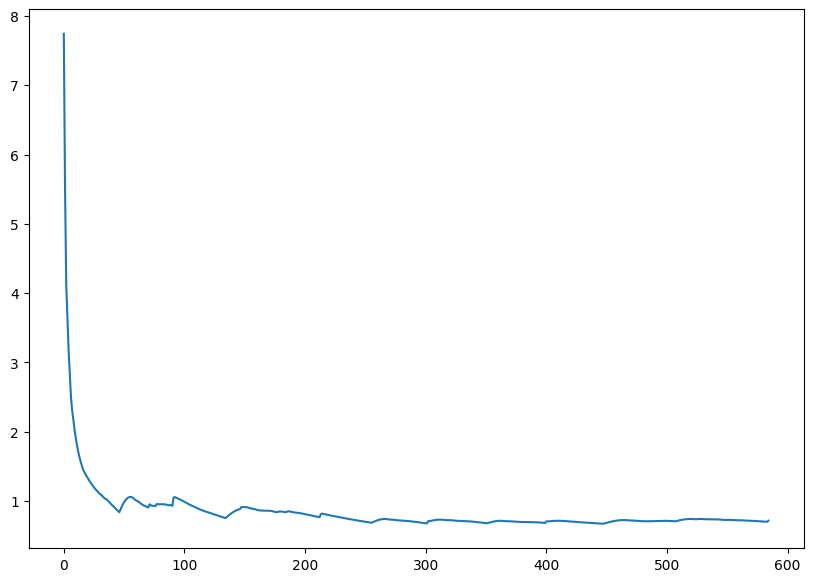

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
k,v = list(losses_dict.keys())[0], list(losses_dict.values())[0]
ax.plot(v, label=k)

In [10]:
env2 = gym.make(id="MountainCarContinuous-v0", render_mode='human')
preprocessor = PreProcessor(env2)
actions = np.array([], dtype=np.float32)
num_episodes = 1
for _ in range(num_episodes):
    try:
        s0, _ = env2.reset()
        env2.render()
        done0, done1 = False, False
        total_reward = 0.
        while not (done0 or done1):
            s0 = np.expand_dims(s0, 0)
            s0 = preprocessor.call(s0)
            action_choice_probs, _ = policy(s0)  # type: ignore
            action, _, _, _ = np.split(action_choice_probs, 4, axis=-1)
            action = np.clip(np.squeeze(action), -1.0, 1.0)
            actions = np.append(actions, float(action))

            s0, reward, done0, done1, _ = env2.step([float(action)])
            env2.render()
            total_reward += reward
        print(total_reward)
    except Exception as e:
        env2.close()
        raise e
env2.close()
actions = np.round(actions, 4)

94.60278154716636


In [11]:
policy.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(1, 2)]             0           []                               
                                                                                                  
 flatten (Flatten)              (1, 2)               0           ['input_1[0][0]']                
                                                                                                  
 dense_2 (Dense)                (1, 64)              192         ['flatten[0][0]']                
                                                                                                  
 dense_3 (Dense)                (1, 64)              192         ['flatten[0][0]']                
                                                                                              

In [12]:
print(len(actions))

323


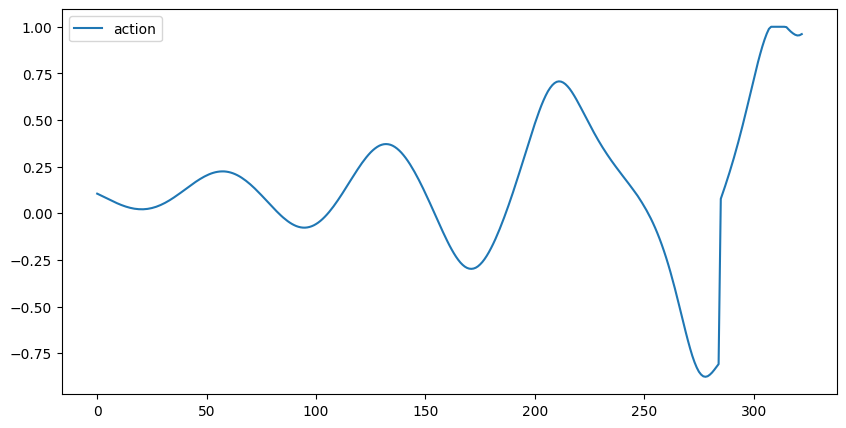

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
ax.plot(actions, label='action')
ax.legend()
plt.show()
plt.close()

In [14]:
policy.save('policy.h5')
p2: tf.keras.Model = tf.keras.models.load_model('policy.h5', custom_objects={'policy_loss': policy_loss, 'params': params}, compile=True) # type: ignore
preprocessor = PreProcessor(env)
s=[0.1, 0.06]
s=np.expand_dims(s, 0)
s=preprocessor.call(s)
print(policy(s))
print(p2(s))

[<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[9.870893e-01, 0.000000e+00, 9.999981e-01, 1.922320e-06]],
      dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.06912115]], dtype=float32)>]
[<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[9.8710406e-01, 0.0000000e+00, 9.9999809e-01, 1.9223201e-06]],
      dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.06912115]], dtype=float32)>]
